We simulate the system

\begin{equation}
	d
	\begin{pmatrix}
		\eta
		\\
		v
	\end{pmatrix}
	=
	J \nabla \mathcal H
	d t
	+
	\sum_i J_i \nabla \mathcal H
	\circ
	d W_i
	,
\end{equation}

with

\begin{equation}
	J
	=
	\begin{pmatrix}
		0 & - K^2 \partial_x
		\\
		- K^2 \partial_x & 0
	\end{pmatrix}
	\quad
	\text{ and }
	\quad
	J_i
	=
	\gamma_i
	\begin{pmatrix}
		g^{-1} \partial_x  & 0
		\\
		0  &  h^{-1} K^2 \partial_x                
	\end{pmatrix}
	,
\end{equation}
and the energy
\begin{equation}
	\mathcal H
	=
	\frac 12 \int_{\mathbb R}
	\left(
		g \eta^2 + h \big( K^{-1}v \big)^2 + \eta v^2
	\right)
	dx
    .
\end{equation}



In [1]:
from __future__ import division
%matplotlib inline
from comparison import *
from travwave.petviashvili import *

Main parameters:

In [2]:
Length = 100
gravity = 1.0
depth = 1.0
Ngrid = 2**10
Ntime = 10**(5 - 0)
Time = 50

epsilon = 0.1
#gamma = np.array([ 1, 1/2, 1/3, 1/4, 1/5, 1/6 ])
gamma = np.array([ 1 ])

gamma = calibrate_noise(gamma, epsilon = epsilon, g = gravity, h = depth)
Ngamma = len(gamma)

time_step = Time / Ntime
sqrt_step = np.sqrt(time_step)
print(time_step)
print(sqrt_step)
print(epsilon)
print(gamma)

0.0005
0.022360679774997897
0.1
[0.4472136]


In [3]:
Z = np.random.normal(size = (Ngamma, Ntime))

In [4]:
Znew = deepcopy(Z)

where each $\{ Z_n^j \} _{n=0}^{\infty}$ is a sequence of independent $N(0, 1)$-distributed
random variables.

We can also use previously saved random values, see next two cells. They are stored in files 'Random_values_Zxx.mat', where xx stands for the number of experiment.

Warning: there is a problem with shape after saving and loading again!
It seems that the type of floating numbers changes during these procedures, which affects slightly the final result.

In [5]:
#name = name_solution_file( 'Experiments', 'Random_values_Z.mat' )
#test_random_values = {
#    'Z' : Z,
#    'gamma' : gamma,
#    'epsilon' : epsilon,
#    'time_step' : time_step,
#    'sqrt_step' : sqrt_step
#}
#scipy.io.savemat(name, test_random_values)

In [6]:
name = name_solution_file( 'Experiments', 'Random_values_Z03.mat' )
Random_values = dict()
scipy.io.loadmat(name, Random_values)
Z = Random_values['Z']
gamma = Random_values['gamma'][0]
epsilon = Random_values['epsilon'][0][0]
time_step = Random_values['time_step'][0][0]
sqrt_step = Random_values['sqrt_step'][0][0]

In [7]:
Zload = deepcopy(Z)

In [8]:
print(np.shape(Znew) == np.shape(Zload))
print(np.shape(Zload))
print(Zload[0])
print(Znew[0])
#plot(Zload[0])
print(gamma)
print(epsilon)
print(time_step)
print(sqrt_step)

True
(1, 100000)
[ 0.48391959  0.73792199  0.33535364 ...  0.56324273 -0.19487843
 -1.42786889]
[-0.18754636 -0.63523574  0.58197633 ...  0.06089552 -0.62410435
  0.62272418]
[0.4472136]
0.1
0.0005
0.022360679774997897


In [9]:
alpha = np.sqrt(gravity * depth**3) * epsilon * time_step
z = np.matmul(gamma, Z) * sqrt_step

Define system in variables $(\eta, v)$:

In [10]:
ham = bidirectional_whitham.Hamiltonian_Hur(Length, Ngrid, gravity, depth)

solve_ham = Solver(
    ham, time_step,
    right_partB_indices = [(0,1), (1,1)]
)

Define initial elevation $\eta_0$:

In [11]:
################################################
x0 = 0
x = ham.nodes
lam = 3.0
a = 0.7
f_lam = 2 / lam * np.log(sqrt(2) + 1)
eta0 = a / ( np.cosh(f_lam * (x - x0)) **2 )
################################################

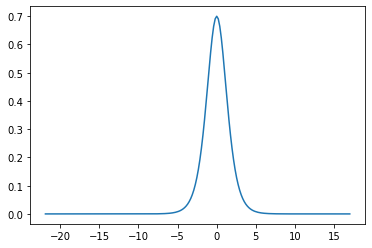

In [12]:
u0 = eta0
u0 = ham.apply_sqrt_gD_over_thHD(u0)
v0 = ham.apply_thHD_over_HD(u0) 
#v0 = 0 * v0
Y1 = np.array([eta0, v0])
plot(ham.nodes[400:600], Y1[0][400:600])

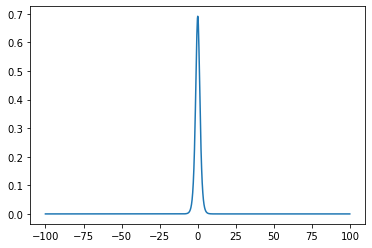

In [13]:
petv = Petviashvili(ham, 1.3)

Solitary = deepcopy(Y1)
for i in range(400):
    Solitary = petv.iteration(Solitary)
plot(ham.nodes, Solitary[0])
#savefig('solitary waves.pdf')

Y1 = Solitary

In [14]:
solution_ham = [ Y1 ]

Define operator
$
    \exp
	\left(
		- \alpha D^2
	\right)
$
as follows 

In [15]:
exp_minus_alphaDD_symbol = np.exp(- alpha * ham.frequencies**2)

def apply_exp_minus_alphaDD(u):
    res0 = ham.apply_operator(u[0], exp_minus_alphaDD_symbol).real
    res1 = ham.apply_operator(u[1], exp_minus_alphaDD_symbol).real
    return np.array([ res0, res1 ])

The explicit Euler scheme for the stochastic nonlinear system in $(\eta, v)$ has the form


\begin{multline*}
	\begin{pmatrix}
		\eta(t_{n+1})
		\\
		v(t_{n+1})
	\end{pmatrix}
	\approx
	\begin{pmatrix}
		\eta_{n+1}
		\\
		v_{n+1}
	\end{pmatrix}
	=
	S(\Delta t) \exp
	\left(
		- \alpha D^2
	\right)
	\\
	\left \{
		\text{expB}(u)
		+
		z(n)
		\begin{pmatrix}
			\partial_x \eta + \frac 1g v \partial_x v 
			\\
			\partial_x v + \frac 1h K^2 \partial_x (\eta v)
		\end{pmatrix}
		+
		\alpha
		\begin{pmatrix}
			\partial_x
			\left[
				\frac 2g v \partial_x v
				+
				\frac 1{gh} v K^2 \partial_x (\eta v)
			\right]			
			\\
			\partial_x
			\left[
				\frac 2h K^2 \partial_x (\eta v)
				+
				\frac 1h K^2
				\left(
					\frac 1g v^2 \partial_x v
					+
					\frac 1h \eta K^2 \partial_x (\eta v)
				\right)
			\right]			
		\end{pmatrix}
	\right \}
	,
\end{multline*}


where


\begin{equation*}
	\text{expB}(u)
	=
	\begin{pmatrix}
		\eta
		-
		K^2 \partial_x (\eta v) \Delta t
		\\
		v
		-
		K^2 \partial_x \left( v^2 / 2 \right) \Delta t
	\end{pmatrix}
    ,
\end{equation*}



and is realised in the following loop

In [16]:
N = Ntime
#N = 5000
for i in range(N):
    u = solution_ham[-1]
    expBu = solve_ham.expB_by_Euler(u, 0, 0)
    eta = u[0]
    v = u[1]
    h = ham.depth
    g = ham.gravity
    KDev = (-1/h) * ham[0,1](u)[0]
    Dv = ham.differentiate(v)
    vDv = v * Dv / g
    expBu[0] = expBu[0] + z[i] * ( ham.differentiate(eta) + vDv )
    expBu[1] = expBu[1] + z[i] * ( Dv + KDev )
    temp = 2 * vDv + v * KDev / g
    temp = alpha * ham.differentiate(temp)
    expBu[0] = expBu[0] + temp
    temp = v * vDv + eta * KDev
    temp = ham.apply_thHD_over_HD(temp) / h + 2 * KDev
    temp = alpha * ham.differentiate(temp)
    expBu[1] = expBu[1] + temp
    temp = apply_exp_minus_alphaDD(expBu)
    solution_ham.append( solve_ham.exact(temp, 0) )

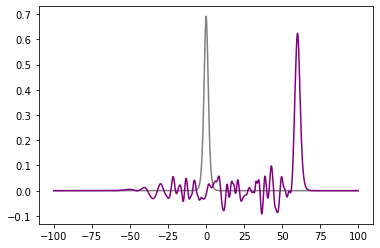

In [17]:
ind = -1
plt.plot(ham.nodes, solution_ham[0][0], 'grey')
plt.plot(ham.nodes, solution_ham[ind][0], 'purple')
savefig('new_Test.pdf')
savefig('new_Test.eps')

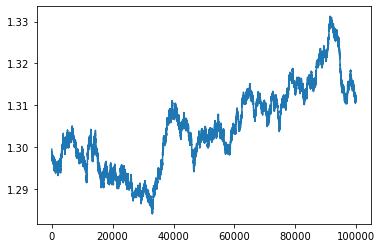

In [18]:
H_ham = []
for sol in solution_ham:
    H_ham.append( ham.Hamiltonian(sol) )
plot(H_ham)

In [19]:
solution_hamEL = [ Y1 ]

Define operators
$
    \exp
	\left(
		iDz(n)
	\right)
$
as follows 

In [20]:
N = Ntime
exp_iDz_symbol = []
for i in range(N):
    exp_iDz_symbol.append( np.exp(1j * ham.frequencies * z[i]) )

def apply_exp_iDz(u, ind):
    res0 = ham.apply_operator(u[0], exp_iDz_symbol[ind]).real
    res1 = ham.apply_operator(u[1], exp_iDz_symbol[ind]).real
    return np.array([ res0, res1 ])

The explicit Euler scheme for the stochastic nonlinear system in $(\eta, v)$ has the form


\begin{multline*}
	\begin{pmatrix}
		\eta(t_{n+1})
		\\
		v(t_{n+1})
	\end{pmatrix}
	\approx
	\begin{pmatrix}
		\eta_{n+1}
		\\
		v_{n+1}
	\end{pmatrix}
	=
	S(\Delta t) \exp
	\left(
		iD z(n)
	\right)
	\\
	\left \{
		\text{expB}(u)
		+
		z(n)
		\begin{pmatrix}
			\frac 1g v \partial_x v 
			\\
			\frac 1h K^2 \partial_x (\eta v)
		\end{pmatrix}
		+
		\alpha
		\begin{pmatrix}
			\partial_x
			\left[
				\frac 1{gh} v K^2 \partial_x (\eta v)
			\right]			
			\\
			\partial_x
			\left[
				\frac 1h K^2
				\left(
					\frac 1g v^2 \partial_x v
					+
					\frac 1h \eta K^2 \partial_x (\eta v)
				\right)
			\right]			
		\end{pmatrix}
	\right \}
	,
\end{multline*}


where


\begin{equation*}
	\text{expB}(u)
	=
	\begin{pmatrix}
		\eta
		-
		K^2 \partial_x (\eta v) \Delta t
		\\
		v
		-
		K^2 \partial_x \left( v^2 / 2 \right) \Delta t
	\end{pmatrix}
    ,
\end{equation*}



and is realised in the following loop

In [21]:
N = Ntime
#N = 5000
for i in range(N):
    u = solution_hamEL[-1]
    expBu = solve_ham.expB_by_Euler(u, 0, 0)
    eta = u[0]
    v = u[1]
    h = ham.depth
    g = ham.gravity
    KDev = (-1/h) * ham[0,1](u)[0]
    Dv = ham.differentiate(v)
    vDv = v * Dv / g
    expBu[0] = expBu[0] + z[i] * vDv
    expBu[1] = expBu[1] + z[i] * KDev
    temp = v * KDev / g
    temp = alpha * ham.differentiate(temp)
    expBu[0] = expBu[0] + temp
    temp = v * vDv + eta * KDev
    temp = ham.apply_thHD_over_HD(temp) / h
    temp = alpha * ham.differentiate(temp)
    expBu[1] = expBu[1] + temp
    temp = apply_exp_iDz(expBu, i)
    solution_hamEL.append( solve_ham.exact(temp, 0) )

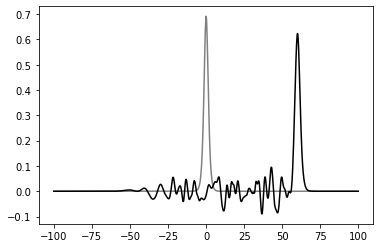

In [22]:
ind = -1
plt.plot(ham.nodes, solution_ham[0][0], 'grey')
#plt.plot(ham.nodes, solution_ham[ind][0], 'purple')
plt.plot(ham.nodes, solution_hamEL[ind][0], 'black')

name = name_solution_file( 'Experiments', 'solution0.' )
savefig( name + 'pdf' )
savefig( name + 'eps' )

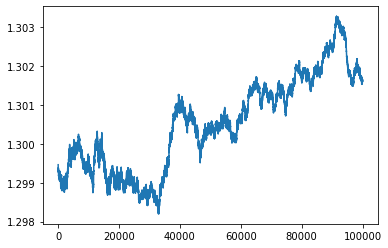

In [23]:
H_hamEL = []
for sol in solution_hamEL:
    H_hamEL.append( ham.Hamiltonian(sol) )
plot(H_hamEL)

In [24]:
solution_hamELM = [ Y1 ]

In [25]:
#Milsteine scheme!
N = Ntime
#N = 5000
for i in range(N):
    u = solution_hamELM[-1]
    expBu = solve_ham.expB_by_Euler(u, 0, 0)
    eta = u[0]
    v = u[1]
    h = ham.depth
    g = ham.gravity
    KDev = (-1/h) * ham[0,1](u)[0]
    Dv = ham.differentiate(v)
    vDv = v * Dv / g
    expBu[0] = expBu[0] + z[i] * vDv
    expBu[1] = expBu[1] + z[i] * KDev
    temp = v * KDev / g
    temp = ( 0.5 * z[i]**2 ) * ham.differentiate(temp)
    expBu[0] = expBu[0] + temp
    temp = v * vDv + eta * KDev
    temp = ham.apply_thHD_over_HD(temp) / h
    temp = ( 0.5 * z[i]**2 ) * ham.differentiate(temp)
    expBu[1] = expBu[1] + temp
    temp = apply_exp_iDz(expBu, i)
    solution_hamELM.append( solve_ham.exact(temp, 0) )

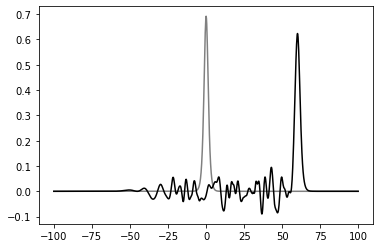

In [26]:
ind = -1
plt.plot(ham.nodes, solution_ham[0][0], 'grey')
#plt.plot(ham.nodes, solution_ham[ind][0], 'purple')
plt.plot(ham.nodes, solution_hamELM[ind][0], 'black')

name = name_solution_file( 'Experiments', 'solution0.' )
savefig( name + 'pdf' )
savefig( name + 'eps' )

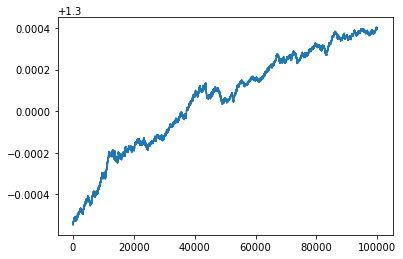

In [27]:
H_hamELM = []
for sol in solution_hamELM:
    H_hamELM.append( ham.Hamiltonian(sol) )
plot(H_hamELM)

In [28]:
############################################################

Here we produce figures for the paper

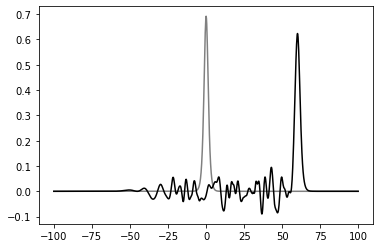

In [29]:
ind = -1
plt.plot(ham.nodes, solution_ham[0][0], 'grey')
plt.plot(ham.nodes, solution_hamELM[ind][0], 'black')

name = name_solution_file( 'Experiments', 'solution0.' )
savefig( name + 'pdf' )
savefig( name + 'eps' )

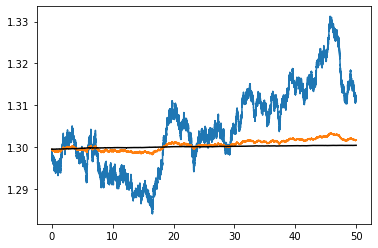

In [30]:
N = len(H_ham)
times = np.linspace(0.0, time_step * (N-1), N)

#plot(times, H_ham_determenistic)
plot(times, H_ham)
plot(times, H_hamEL) #, 'orange'
plot(times, H_hamELM, 'black')


name = name_solution_file( 'Experiments', 'Energy0.' )
savefig( name + 'pdf' )
savefig( name + 'eps' )

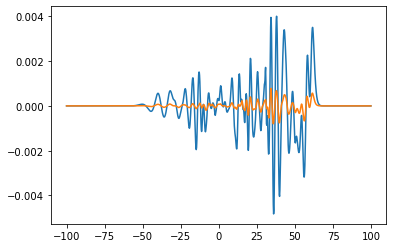

In [31]:
ind = -1

temp = solution_ham[ind][0] - solution_hamELM[ind][0]
plt.plot(ham.nodes, temp) #, 'blue'

temp = solution_hamEL[ind][0] - solution_hamELM[ind][0]
plt.plot(ham.nodes, temp) #, 'orange'

name = name_solution_file( 'Experiments', 'difference0.' )
savefig( name + 'pdf' )
savefig( name + 'eps' )

Fourier transform
\begin{equation*}
    \widehat u (\xi)
    =
    \mathcal F u(\xi)
    =
    \int e^{-i\xi x} u(x) dx
    \approx
    ( x_1 - x_0 ) \sum _{n = 0}^{N-1}
    e^{-i\xi x_n} u(x_n)
    =
    ( x_1 - x_0 ) \mbox{ FFT}(u)(\xi)
\end{equation*}

We need to plot the dependence of $\log_{10} | \widehat \eta (\xi) |$ on $\xi$

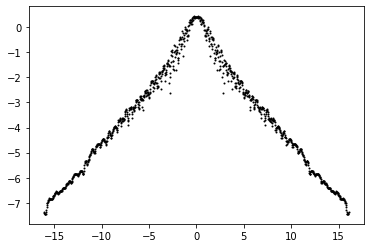

In [32]:
ind = -1
u = solution_hamELM[ind][0]
u = scipy.fftpack.fft(u)

u = ( ham.nodes[1] - ham.nodes[0] ) * abs(u)
u = np.log10(u)

redundant = np.argmin(ham.frequencies)
freq = np.concatenate([ ham.frequencies[ 0 : redundant ], ham.frequencies[ redundant + 1 : ]  ])
spec = np.concatenate([ u[ 0 : redundant ], u[ redundant + 1 : ]  ])
#print(np.size(freq))
#print(np.size(temp))

plot(freq, spec, '.', markersize = 2, color = 'black')

name = name_solution_file( 'Experiments', 'log_spectrum0.' )
savefig( name + 'pdf' )
savefig( name + 'eps' )